<a href="https://colab.research.google.com/github/tanatiem/campaign-response/blob/main/notebooks/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Campaign Response Model - Hyperparameter Tuning

Hyperparameter Tuning for XGBoost.

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 35.5 MB/s 
     |████████████████████████████████| 209 kB 73.6 MB/s 
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 78 kB 2.8 MB/s 
     |████████████████████████████████| 112 kB 65.0 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 147 kB 73.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=23d593724f740c35a7c9ddcbfd26f0b43f0b8955384d532c8057edf9ad90d963
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb

import optuna
from optuna.samplers import TPESampler, MOTPESampler

import plotly.express as px
from tqdm import tqdm

In [5]:
train_url = "https://raw.githubusercontent.com/tanatiem/campaign-response/main/datasets/train.csv"
test_url = "https://raw.githubusercontent.com/tanatiem/campaign-response/main/datasets/test.csv"

train_df = pd.read_csv(train_url, index_col=0)
test_df = pd.read_csv(test_url, index_col=0)

X = train_df.copy() 
y = X.pop('response')
X_test = test_df.copy()
y_test = X_test.pop('response')

scale_pos_weight = (len(y) - sum(y)) / sum(y)
random_state = 61
cv = StratifiedKFold(5, shuffle=True, random_state=random_state)
prep = Pipeline(steps=[('scaler', StandardScaler())])

In [ ]:
# Helper
def xgb_cv(X, y, params, cv, random_state=0):
    train_scores, val_scores = [],[]
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        prep.fit(X_train)
        X_train = pd.DataFrame(prep.transform(X_train), columns=X.columns)
        X_val = pd.DataFrame(prep.transform(X_val), columns=X.columns)

        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
        train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
    return train_scores, val_scores

# 1st Iteration

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'max_depth' : trial.suggest_int('max_depth', 2, 5),
        'learning_rate' : trial.suggest_float('learning_rate', .01, .5, log=True),
        'subsample' : trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'colsample_bylevel' : trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'reg_alpha' : trial.suggest_loguniform('reg_alpha', .01, 100.0),
        'reg_lambda' : trial.suggest_loguniform('reg_lambda', .01, 100.0),
        'gamma' : trial.suggest_loguniform('gamma', .01, 100.0),
        'min_child_weight' : trial.suggest_int('min_child_weight', 0, 20),
        'tree_method' : trial.suggest_categorical('tree_method', ['approx','gpu_hist','hist']),
        # fixed
        'nthread' : -1,
        'scale_pos_weight' : scale_pos_weight,
        'random_state' : random_state,
        # 'predictor' : 'gpu_predictor',
    }

    train_scores, val_scores = xgb_cv(X, y, params, cv, random_state=random_state)
    trial.set_user_attr('val_std', np.std(val_scores))
    trial.set_user_attr('train_mean', np.mean(train_scores))
    trial.set_user_attr('train_std', np.std(train_scores))
    return np.mean(val_scores)

study1 = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
study1.optimize(objective, n_trials=500, show_progress_bar=True)

In [ ]:
t = study1.best_trial
print(f"Best Trial: {t.number}")
print(f"best value: {t.value},     val-std: {t.user_attrs['val_std']}")
print(f"train-mean: {t.user_attrs['train_mean']}, train-std: {t.user_attrs['train_std']}")
t.params

Best Trial: 458
best value: 0.8041020346273967,     val-std: 0.013915922410919613
train-mean: 0.8194941658277054, train-std: 0.010760768924392677


{'colsample_bylevel': 0.2288261890079543,
 'colsample_bynode': 0.14886204843082254,
 'colsample_bytree': 0.9858229190275916,
 'gamma': 24.444816871569035,
 'learning_rate': 0.2368180810645666,
 'max_depth': 2,
 'min_child_weight': 5,
 'reg_alpha': 0.28386279109965007,
 'reg_lambda': 5.357104605508783,
 'subsample': 0.6091473531576421,
 'tree_method': 'approx'}

In [ ]:
result = study1.trials_dataframe()
fig = px.scatter(result, x='value', y='user_attrs_val_std', hover_data=['number'], opacity=.7, 
                 color='number', color_continuous_scale=px.colors.sequential.Sunsetdark,
                 title='Cross-Validation AUC Mean vs SD')
fig.show()

In [ ]:
optuna.visualization.plot_optimization_history(study1)

In [ ]:
optuna.visualization.plot_slice(study1)

# 2nd Iteration
Narrowing search spaces using the result from the 1st attempt.

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'max_depth' : 2,
        'learning_rate' : trial.suggest_float('learning_rate', .2, .3),
        'subsample' : trial.suggest_float('subsample', 0.55, 0.65),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.85, 1.0),
        'colsample_bylevel' : trial.suggest_float('colsample_bylevel', 0.2, .35),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.1, .5),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0.2, 6.0),
        'reg_lambda' : trial.suggest_float('reg_lambda', 1.5, 25.0),
        'gamma' : trial.suggest_float('gamma', 0.01, 25.0),
        'min_child_weight' : 5,
        'tree_method' : 'approx',
        'nthread' : -1,
        'scale_pos_weight' : scale_pos_weight,
        'random_state' : random_state,
    }

    train_scores, val_scores = xgb_cv(X, y, params, cv, random_state=random_state)
    trial.set_user_attr('val_std', np.std(val_scores))
    trial.set_user_attr('train_mean', np.mean(train_scores))
    trial.set_user_attr('train_std', np.std(train_scores))
    return np.mean(val_scores)

study2 = optuna.create_study(direction='maximize', sampler=TPESampler(seed=random_state))
study2.optimize(objective, n_trials=500, show_progress_bar=True)

In [ ]:
t = study2.best_trial
print(f"Best Trial: {t.number}")
print(f"best value: {t.value},     val-std: {t.user_attrs['val_std']}")
print(f"train-mean: {t.user_attrs['train_mean']}, train-std: {t.user_attrs['train_std']}")
t.params

Best Trial: 10
best value: 0.8045444765666835,     val-std: 0.01337688145261534
train-mean: 0.8149226140629166, train-std: 0.01093354358538432


{'colsample_bylevel': 0.3453532585294885,
 'colsample_bynode': 0.10727928252410016,
 'colsample_bytree': 0.9008153731042564,
 'gamma': 17.499806613284175,
 'learning_rate': 0.2512943257292035,
 'reg_alpha': 5.070839755319599,
 'reg_lambda': 18.480931082121078,
 'subsample': 0.6359076080106976}

In [ ]:
result = study2.trials_dataframe()
fig = px.scatter(result, x='value', y='user_attrs_val_std', hover_data=['number'], opacity=.7, 
                 color='number', color_continuous_scale=px.colors.sequential.Sunsetdark,
                 title='Cross-Validation AUC Mean vs SD')
fig.show()

In [ ]:
optuna.visualization.plot_optimization_history(study2)

In [ ]:
optuna.visualization.plot_slice(study2)

# Finding an appropriate number of estimators


In [ ]:
# best params
params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'auc',
    'nthread' : -1,
    'scale_pos_weight' : scale_pos_weight,
    'random_state' : random_state,
    # tuned
    'tree_method' : 'approx',
    'max_depth' : 2,
    'min_child_weight' : 5,
    'colsample_bylevel': 0.3453532585294885,
    'colsample_bynode': 0.10727928252410016,
    'colsample_bytree': 0.9008153731042564,
    'gamma': 17.499806613284175,
    'learning_rate': 0.2512943257292035,
    'reg_alpha': 5.070839755319599,
    'reg_lambda': 18.480931082121078,
    'subsample': 0.6359076080106976,
}
num_tree = np.arange(1,101)
train_cv_scores, val_cv_scores = [], []
x = []
for i in tqdm(num_tree):
    
    train_scores, val_scores = [], []
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        prep.fit(X_train)
        X_train = pd.DataFrame(prep.transform(X_train), columns=X.columns)
        X_val = pd.DataFrame(prep.transform(X_val), columns=X.columns)

        model = xgb.XGBClassifier(**params, n_estimators=i)
        model.fit(X_train, y_train, verbose=False)
        train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
        val_scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
    
    x.append(i)
    train_cv_scores.append(np.mean(train_scores))
    val_cv_scores.append(np.mean(val_scores))

df = pd.DataFrame({'num_tree': x, 'val' : val_cv_scores, 'train' : train_cv_scores})
df = df.melt('num_tree', var_name='set', value_name='auc')
fig = px.line(df, x='num_tree', y='auc', color='set', markers=True)
fig.show()

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


In [ ]:
maxidx = val_cv_scores.index(max(val_cv_scores))
x[maxidx], val_cv_scores[maxidx], train_cv_scores[maxidx]

(9, 0.7991851473454099, 0.8119109208804117)

# Tuning Result

Train AUC: 0.8181499298456605
Test  AUC: 0.8009093619558736


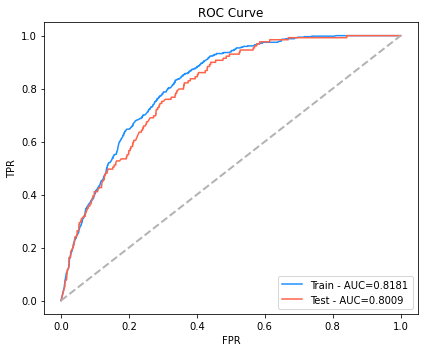

In [22]:
# final param 
params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'auc',
    'nthread' : -1,
    'scale_pos_weight' : scale_pos_weight,
    'random_state' : random_state,
    # tuned
    'tree_method' : 'approx',
    'max_depth' : 2,
    'min_child_weight' : 5,
    'colsample_bylevel': 0.3453532585294885,
    'colsample_bynode': 0.10727928252410016,
    'colsample_bytree': 0.9008153731042564,
    'gamma': 17.499806613284175,
    'learning_rate': 0.2512943257292035,
    'reg_alpha': 5.070839755319599,
    'reg_lambda': 18.480931082121078,
    'subsample': 0.6359076080106976,
    'n_estimators' : 16
}

clf = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('clf', xgb.XGBClassifier(**params))
                        ])

X_train = train_df.copy()
y_train = X_train.pop('response')
X_test = test_df.copy()
y_test = X_test.pop('response')

clf.fit(X_train, y_train, clf__verbose=False)

y_train_score = clf.predict_proba(X_train)[:,1]
y_test_score = clf.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
auc_train = roc_auc_score(y_train, y_train_score)
auc_test = roc_auc_score(y_test, y_test_score)

print(f"Train AUC: {auc_train}")
print(f"Test  AUC: {auc_test}")

plt.figure(figsize=(6,5), tight_layout=True)
plt.plot(fpr_train, tpr_train, color='dodgerblue', label=f'Train - AUC={round(auc_train,4)}')
plt.plot(fpr_test, tpr_test, color='tomato', label=f'Test - AUC={round(auc_test,4)}')
plt.plot([0, 1], [0, 1], color='.7', lw=2, linestyle='--')
plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.legend(loc=4)
plt.show()

In [23]:
import joblib
joblib.dump(clf, 'model.pkl')

['model.pkl']